<a href="https://colab.research.google.com/github/thdwldud/dacon/blob/main/dacon_movie_high.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 영화 관객 예측

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv("movies_train.csv")
test = pd.read_csv('movies_test.csv')
submission = pd.read_csv('submission.csv')

In [ ]:
train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


In [ ]:
test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


In [ ]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


## 배급사 전처리

In [ ]:
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

In [ ]:
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [ ]:
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [ ]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

## 장르별 영화 관객수 평균값으로 랭크 인코딩

In [ ]:
train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [ ]:
train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

## 배급사별 영화 관객 수 중위값 기준으로 배급사 랭크 인코딩

In [ ]:
tr_nm_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'num_rank').sort_values(by = 'num_rank')
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
52,사람과사람들,42.0
97,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
113,전망좋은영화사,1214237.0
105,이십세기폭스코리아,1422844.0
56,쇼박스,2138560.0
84,영구아트무비,2541603.0


In [ ]:
tr_nm_rank['num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]

In [ ]:
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,1
15,고구마공작소,2
52,사람과사람들,3
97,위드시네마,4
19,나우콘텐츠,5
...,...,...
113,전망좋은영화사,143
105,이십세기폭스코리아,144
56,쇼박스,145
84,영구아트무비,146


In [ ]:
train = pd.merge(train, tr_nm_rank, how = 'left')

In [ ]:
test = pd.merge(test, tr_nm_rank, how = 'left')

In [ ]:
train['dir_prev_bfnum'].fillna(0, inplace=True)

In [ ]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,num_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,11,134
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12,145
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11,145
3,나는 공무원이다,NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,9,140
4,불량남녀,쇼박스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,9,145


In [ ]:
test.fillna(0, inplace = True)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [ ]:
train.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num', 'genre_rank', 'num_rank'],
      dtype='object')

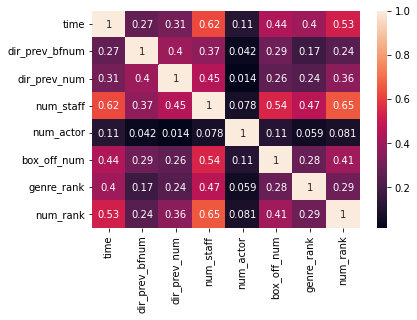

In [ ]:
sns.heatmap(train.corr(), annot = True)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['genre'] = le.fit_transform(train['genre']) # 값들을 다 숫자로 바꿔줌

In [ ]:
features = ['time', 'num_staff', 'genre_rank', 'num_actor', 'num_rank']
target = ['box_off_num']

In [ ]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [ ]:
test.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'genre_rank', 'num_rank'],
      dtype='object')

In [ ]:
import lightgbm as lgb

In [ ]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

In [ ]:
# 답안지 복사
singleLGBM = submission.copy()

In [ ]:
singleLGBM['box_off_num'] = model.predict(X_test)

In [ ]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,1.572423e+06
1,아빠가 여자를 좋아해,5.769011e+05
2,하모니,1.267722e+06
3,의형제,2.155725e+06
4,평행 이론,1.934298e+06


In [ ]:
singleLGBM.to_csv('singleLGBM.csv', index = False)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
k_fold = KFold(n_splits= 5, shuffle = True, random_state = 777)

In [ ]:
model = lgb.LGBMRegressor(random_state= 777, n_estimators= 1000)

# 모델 5개 담을 바구니
models = []

for train_idx, val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]
  
  models.append(model.fit(x_t, y_t, eval_set = (x_val, y_val), early_stopping_rounds = 100, verbose = 100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.50005e+12
Early stopping, best iteration is:
[16]	valid_0's l2: 2.27079e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.87149e+12
Early stopping, best iteration is:
[32]	valid_0's l2: 3.62587e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.0781e+12
Early stopping, best iteration is:
[25]	valid_0's l2: 2.3752e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.61935e+12
Early stopping, best iteration is:
[12]	valid_0's l2: 1.06972e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.48433e+12
Early stopping, best iteration is:
[28]	valid_0's l2: 1.31625e+12


In [ ]:
preds =[]
for model in models:
  preds.append(model.predict(X_test))
len(preds)

5

In [ ]:
kfoldLightGBM = submission.copy() # 답안지 복사

In [ ]:
import numpy as np # 예측값의 평균을 구하기 위해 numpy 임포트

In [ ]:
# 예측값들이 5세트가 입력되어 있음
# 축을 0으로 두고 이것들의 평균을 내기
kfoldLightGBM['box_off_num'] = np.mean(preds, axis =0)

In [ ]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,2.368490e+06
1,아빠가 여자를 좋아해,1.433713e+06
2,하모니,1.403811e+06
3,의형제,2.294302e+06
4,평행 이론,8.758282e+05


In [ ]:
kfoldLightGBM.to_csv('kfoldLightGBM.csv', index = False)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from re import M
model = lgb.LGBMRegressor(random_state= 777, n_estimators=1000)

# 6개 조합의 파라미터
# learning_rate: 모델링을 하는 간격. 순차적으로 진행할 때 기존 모델에 대한 성능을 얼마나 다음 모델에 반영할 것인지. 값이 적을 수록 미세하게 변화
params ={
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.1, 0.01, 0.003],
    'max_features': [2, 4, 6, 8, 10],
    'min_child_samples':[20,30]}

# scoring 을 rmse로 한 이유는 현재 이 대회의 평가지표가 rmse값이기 때문
gs = GridSearchCV(estimator=model,
                  param_grid = params,
                  scoring = 'neg_mean_squared_error',
                  cv = k_fold) # cv = 5 해도 같음

In [ ]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'max_features': [2, 4, 6, 8, 10],
                         'min_child_samples': [20, 30],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='neg_mean_squared_error')

In [ ]:
# 가장 좋은 파라미터 조합
gs.best_params_

{'learning_rate': 0.01,
 'max_features': 2,
 'min_child_samples': 30,
 'n_estimators': 250}

In [ ]:
model = lgb.LGBMRegressor(random_state= 777, n_estimators=250, learning_rate = 0.01, max_features= 2, min_child_samples=30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]
  
  models.append(model.fit(x_t, y_t, eval_set = (x_val, y_val), early_stopping_rounds = 100, verbose = 100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.23538e+12
[200]	valid_0's l2: 2.27999e+12
Early stopping, best iteration is:
[102]	valid_0's l2: 2.23214e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 4.02053e+12
[200]	valid_0's l2: 3.64522e+12
Did not meet early stopping. Best iteration is:
[250]	valid_0's l2: 3.55711e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.62571e+12
[200]	valid_0's l2: 2.47478e+12
Did not meet early stopping. Best iteration is:
[249]	valid_0's l2: 2.41175e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.10723e+12
[200]	valid_0's l2: 1.03456e+12
Did not meet early stopping. Best iteration is:
[183]	valid_0's l2: 1.03247e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.51169e+12
[200]	valid_0's l2: 1.31143e+12
Did not meet early stopping. Best iteration is:
[243]	vali

In [ ]:
preds =[]
for model in models:
  preds.append(model.predict(X_test))

In [ ]:
gs.best_score_

-2121675757143.798

In [ ]:
gslgbm = submission.copy()

In [ ]:
gslgbm['box_off_num'] = np.mean(preds, axis = 0)

In [ ]:
gslgbm.to_csv('gslgbm_2.csv', index = False)